In [40]:
from math import sin, cos, log
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [41]:
# model parameters:
g = 9.8        # gravity in m/s^2
v_t = 4.9      # trim velocity in m/s
C_D = 1/5.0    # drag coefficient --- or D/L if C_L = 1
C_L = 1.0      # for convenience, use C_L = 1

### set initial conditions ###
v0 = 6.5       # start at the trim velocity (or add a delta)
theta0 = -0.1  # initial angle of the trajectory
x0 = 0.0       # horizontal position is arbitrary
y0 = 2.0       # initial altitude

In [42]:
def f(u):
    """Returns the right-hand side of the phugoid system of equations.
    
    Parameters
    ----------
    u : array of float
        array containing the solution at time n.
        
    Returns
    -------
    dudt : array of float
        array containing the RHS given u.
    """
    
    v = u[0]
    theta = u[1]
    x = u[2]
    y = u[3]
    return numpy.array([-g*sin(theta) - C_D/C_L*g/v_t**2*v**2, -g*cos(theta)/v + g/v_t**2*v, v*cos(theta), v*sin(theta)])


def euler_step(u, f, dt):
    """Returns the solution at the next time-step using Euler's method.
    
    Parameters
    ----------
    u : array of float
        solution at the previous time-step
    f : function
        function to compute the right hand-side of the system of equation.
    dt : float
        time-increment.
        
    Returns
    -------
    u_n_plus_1 : array of float
        approximate solution at the next time step.
    """
    
    return u + dt * f(u)

def get_diffgrid(u_current, u_fine, dt):
    """Returns the difference between one grid and the fine one using L-1 norm.
    
    Parameters
    ----------
    u_current : array of float
        solution on the current gird.
    u_finest : array of float
        solution on the finest grid.
    dt : float
        time-increment on the current grid.
        
    Returns
    -------
    diffgrid : float
        difference computed using the L-1 norm.
    """
    
    N_current = len(u_current[:,0])
    N_fine = len(u_fine[:,0])
    
    grid_size_ratio = numpy.ceil(N_fine/N_current)
    
    diffgrid = dt * numpy.sum(numpy.abs(u_current[:,2] - u_fine[::grid_size_ratio,2]))
    
    return diffgrid

In [43]:
def rk2_step(u, f, dt):
    """Returns the solution at the next time-step using 2nd-order Runge-Kutta.
    
    Parameters
    ----------
    u : array of float
        solution at the previous time-step.
    f : function
        function to compute the right hand-side of the system of equation.
    dt : float
        time-increment.
        
    Returns
    -------
    u_n_plus_1 : array of float
        solution at the next time step.
    """
    u_star = u + 0.5*dt*f(u)
    return u + dt * f(u_star)

In [44]:
# set time-increment and discretize the time
T = 15.0                # final time
dt = 0.01               # set time-increment
N = int(T/dt) + 1       # number of time-steps

# set initial conditions
u_euler = numpy.empty((N,4))
u_rk2   = numpy.empty((N,4))

# initialize the array containing the solution for each time-step
u_euler[0] = numpy.array([v0, theta0, x0, y0])
u_rk2[0]   = numpy.array([v0, theta0, x0, y0])

# use a for loop to call the function rk2_step()
for n in range(N-1):
    u_euler[n+1] = euler_step(u_euler[n], f, dt)
    u_rk2[n+1]   = rk2_step(u_rk2[n], f, dt)

In [45]:
# get the position the glider for both Euler's method and 2nd order Runge-Kutta method
x_euler = u_euler[:,2]
y_euler = u_euler[:,3]
x_rk2   = u_rk2[:,2]
y_rk2   = u_rk2[:,3]

In [46]:
# get the index of elements of y where the altitude becomes negative
idx_negative_euler = numpy.where(y_euler<0.0)[0]
if len(idx_negative_euler)==0:
    idx_ground_euler = N-1
    print ('Euler integration has not touched the ground yet!')
else:
    idx_ground_euler = idx_negative_euler[0]
    
idx_negative_rk2 = numpy.where(y_rk2<0.0)[0]
if len(idx_negative_rk2)==0:
    idx_ground_rk2 = N-1
    print ('Runge-Kutta integration has not touched the ground yet!')
else:
    idx_ground_rk2 = idx_negative_rk2[0]

In [47]:
# Check to see if the paths are close (Default within 10^-5)
print ('Are the x-values close?: {}'.format(numpy.allclose(x_euler,x_rk2)))
print ('Are the y-values close?: {}'.format(numpy.allclose(y_euler,y_rk2)))

Are the x-values close?: False
Are the y-values close?: False


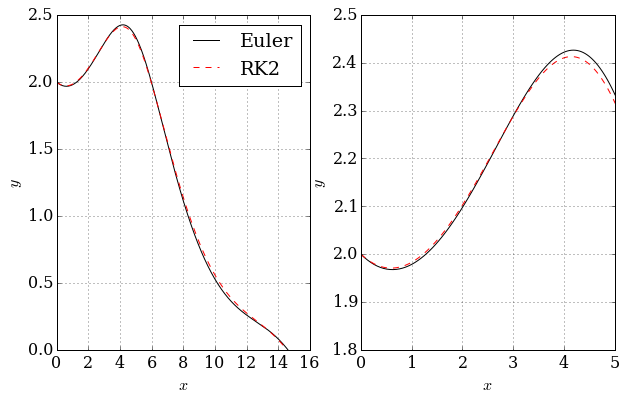

In [48]:
# plot the glider path
pyplot.figure(figsize=(10,6))
pyplot.subplot(121)
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.plot(x_euler[:idx_ground_euler], y_euler[:idx_ground_euler], 'k-', label='Euler')
pyplot.plot(x_rk2[:idx_ground_rk2], y_rk2[:idx_ground_rk2], 'r--', label='RK2')
pyplot.legend();

# Let's take a closer look!
pyplot.subplot(122)
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.plot(x_euler,y_euler,'k-',label = 'Euler')
pyplot.plot(x_rk2,y_rk2, 'r--', label = 'RK2')
pyplot.xlim(0,5)
pyplot.ylim(1.8,2.5);

In [49]:
# use a for-loop to compute the solution on different grids
dt_values = numpy.array([0.1, 0.05, 0.005, 0.001])

u_values = numpy.empty_like(dt_values, dtype=numpy.ndarray)

for i, dt in enumerate(dt_values):
    
    N = int(T/dt) + 1  # number of time-steps
    
    ### discretize the time t ###
    t = numpy.linspace(0.0,T,N)
    
    # initialize the array containing the solution for each time-step
    u = numpy.empty((N,4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    
    # time loop
    for n in range(N-1):
        u[n+1] = rk2_step(u[n], f, dt)
        
    # store the value of the u related to one grid
    u_values[i] = u

In [50]:
# compute diffgrid
diffgrid = numpy.empty_like(dt_values)
for i, dt in enumerate(dt_values):
    diffgrid[i] = get_diffgrid(u_values[i], u_values[-1], dt)

/Users/Michael/Applications/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:65: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


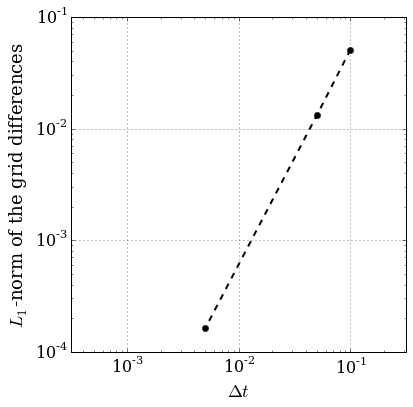

In [51]:
# plot using the matplotlib function loglog()
pyplot.figure(figsize=(6,6))
pyplot.grid(True)
pyplot.xlabel(r'$\Delta t$', fontsize=18)
pyplot.ylabel(r'$L_1$-norm of the grid differences', fontsize=18)
pyplot.xlim(1e-4, 1)
pyplot.ylim(1e-4, 1)
pyplot.axis('equal')
pyplot.loglog(dt_values[:-1], diffgrid[:-1], color='k', ls='--', lw=2, marker='o')

In [52]:
# check convergence rate
r = 2
h = 0.001

dt_values = numpy.array([h, r*h, r**2*h])

u_values = numpy.empty_like(dt_values, dtype=numpy.ndarray)

for i, dt in enumerate(dt_values):
    
    N = int(T/dt) + 1    # number of time-steps
    
    ### discretize the time t ###
    t = numpy.linspace(0.0,T,N)
    
    # initialize the array containing the solution for each time-step
    u = numpy.empty((N,4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    
    # time loop
    for n in range(N-1):
        # call rk2_step() #
        u[n+1] = rk2_step(u[n], f, dt)
        
    # store the value of u related to one grid
    u_values[i] = u
    
# calculate the order of convergence
alpha = (log(get_diffgrid(u_values[2], u_values[1], dt_values[2])) - log(get_diffgrid(u_values[1], u_values[0], dt_values[1]))) / log(r)

print('The order of convergence is alpha = {:.3f}'.format(alpha))

The order of convergence is alpha = 1.983


/Users/Michael/Applications/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:65: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [53]:
def leapfrog_step(unm1, u, f, dt):
    """Returns the solution time-step n+1 using Euler's method.
    
    Parameters
    ----------
    unm1 : array of float
        solution at time-step n-1.
    u : array of float
        solution at time-step n.
    f : function
        function to compute the right hand-side of the system of equation.
    dt : float
        time-increment.
        
    Returns
    -------
    u_n_plus_1 : array of float
        solution at time-step n+1.
    """
    return unm1 + 2.0*dt*f(u)

In [54]:
# model parameters:
g = 9.8          # gravity in m/s^2
v_t = 4.9        # trim velocity in m/s
C_D = 1/5.0      # drag coefficient
C_L = 1.0        # lift coefficient

### set initial conditions ###
v0 = 6.5         # start at the trim velocity or add a delta
theta0 = -0.1    # initial angle of the trajectory
x0 = 0.0         # horizontal position is arbitrary
y0 = 2.0         # initial altitude

# set time-increment and discretize the time
T = 15.0             # final time
dt = 0.01            # set time-increment
N = int(T/dt) + 1    # number of time-steps

# set initial conditions
u_leapfrog = numpy.empty((N,4))

# initialize the array containing the solution for each time-step
u_leapfrog[0] = numpy.array([v0, theta0, x0, y0])

# first step using RK2
u_leapfrog[1] = rk2_step(u_leapfrog[0], f, dt)

In [55]:
# use a for loop to call the function leapfrog_step()
for n in range(1,N-1):
    
    u_leapfrog[n+1] = leapfrog_step(u_leapfrog[n-1], u_leapfrog[n], f, dt)

In [56]:
# get the glider position in time
x_leapfrog = u_leapfrog[:,2]
y_leapfrog = u_leapfrog[:,3]

# get the index of element of y where altitude becomes negative
idx_negative_leapfrog = numpy.where(y_leapfrog<0.0)[0]

if len(idx_negative_leapfrog)==0:
    idx_ground_leapfrog = N-1
    print ('The glider has not reached the ground yet!')
else:
    idx_ground_leapfrog = idx_negative_leapfrog[0]

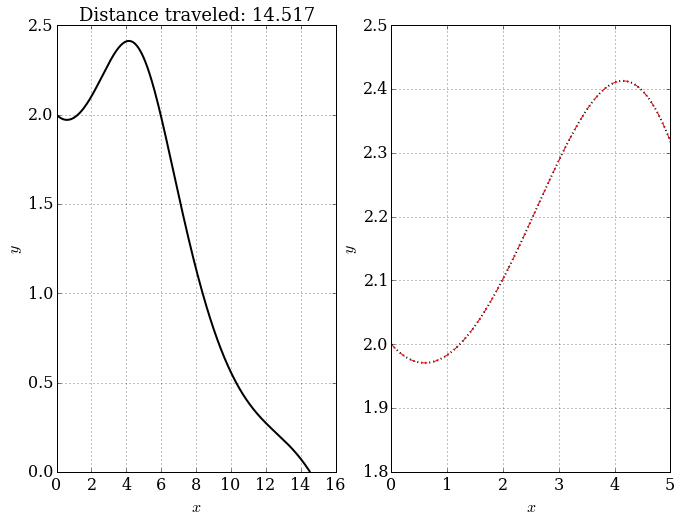

In [57]:
# plot the glider path
pyplot.figure(figsize=(11,8))
pyplot.subplot(121)
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.plot(x_leapfrog[:idx_ground_leapfrog], y_leapfrog[:idx_ground_leapfrog], color='k', ls='-', lw=2)
pyplot.title('Distance traveled: {:.3f}'.format(x_leapfrog[idx_ground_leapfrog-1]), fontsize=18);

# Let's take a closer look!
pyplot.subplot(122)
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.plot(x_leapfrog[:idx_ground_leapfrog], y_leapfrog[:idx_ground_leapfrog], color='k', ls=':', lw=2)
pyplot.plot(x_rk2, y_rk2, 'r--', label='RK2')
pyplot.xlim((0,5))
pyplot.ylim(1.8,2.5);

In [58]:
# check convergence rate
r = 2
h = 0.001

dt_values = numpy.array([h, r*h, r**2*h])

u_values = numpy.empty_like(dt_values, dtype=numpy.ndarray)

for i, dt in enumerate(dt_values):
    
    N = int(T/dt) + 1 # number of time-steps
    
    ### discretize the time t ###
    t = numpy.linspace(0.0, T, N)
    
    # initialize the array containing the solution for each time-step
    u = numpy.empty((N,4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    
    # time loop
    u[1] = rk2_step(u[0], f, dt)
    for n in range(1,N-1):
        u[n+1] = leapfrog_step(u[n-1], u[n], f, dt)
        
    # store the values of u related to one grid
    u_values[i] = u
    
# calculate the order of convergence
alpha = (log(get_diffgrid(u_values[2], u_values[1], dt_values[2])) - log(get_diffgrid(u_values[1], u_values[0], dt_values[1]))) / log(r)

print('The order of convergence is alpha = {:.3f}'.format(alpha))

The order of convergence is alpha = 2.186


/Users/Michael/Applications/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:65: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
